In [2]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime 
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

<ipython-input-2-a9ff8d01cf87>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [39]:
import os
for dirname, _, filenames in os.walk('data/'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

In [40]:
symbols = ['a','aa']

In [41]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("data_stock/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

In [22]:
os.getcwd()

'/Users/user/Documents/stock-prediction-on-lstm'

                 a      aa
2015-01-02  39.431  34.584
2015-01-05  38.692  32.578
2015-01-06  38.089  32.822
2015-01-07  38.596  33.671
2015-01-08  39.751  34.628
...            ...     ...
2016-12-26     NaN     NaN
2016-12-27  46.065  29.650
2016-12-28  45.282  29.430
2016-12-29  45.334  28.890
2016-12-30  45.254  28.080

[521 rows x 2 columns]


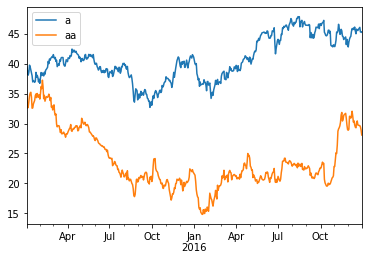

In [42]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['a','aa']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
print(df)
df.interpolate().plot()
plt.show()

In [43]:
df.head()

,a,aa
2015-01-02,39.431,34.584
2015-01-05,38.692,32.578
2015-01-06,38.089,32.822
2015-01-07,38.596,33.671
2015-01-08,39.751,34.628


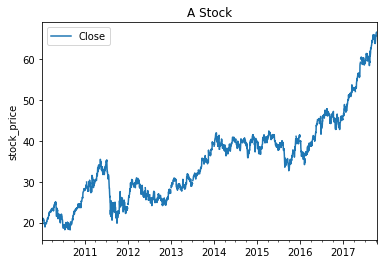

In [44]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("data_stock/Stocks/a.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot()
plt.ylabel("stock_price")
plt.title("A Stock")
plt.show()

In [45]:
df_ibm=df_ibm[['Close']]
df_ibm.head()

,Close
2010-01-04,21.128
2010-01-05,20.899
2010-01-06,20.825
2010-01-07,20.798
2010-01-08,20.791


In [46]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))

In [48]:
def load_data(stock,look_back):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size) 
    x_train = data[:train_set_size,:-1,:] #(1606,19,1)
    y_train = data[:train_set_size,-1,:]
    x_test  = data[train_set_size:,:-1,:]
    y_test  = data[train_set_size:,-1,:]
    return [x_train,y_train,x_test,y_test]

In [49]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1606, 19, 1)
y_train.shape =  (1606, 1)
x_test.shape =  (402, 19, 1)
y_test.shape =  (402, 1)


In [50]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [51]:
y_train.size(),x_train.size()

(torch.Size([1606, 1]), torch.Size([1606, 19, 1]))

In [52]:
n_steps = look_back-1
batch_size = 1606
num_epochs = 100

In [53]:
train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [54]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    

In [55]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/Users/user/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [56]:
# train model
hist = np.zeros(num_epochs)
seq_dim = look_back-1
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.040629032999277115
Epoch  20 MSE:  0.009415085427463055
Epoch  30 MSE:  0.002887076698243618
Epoch  40 MSE:  0.002508798846974969
Epoch  50 MSE:  0.0019208210287615657
Epoch  60 MSE:  0.0016186791472136974
Epoch  70 MSE:  0.0014586157631129026
Epoch  80 MSE:  0.0013547149719670415
Epoch  90 MSE:  0.0012889831559732556


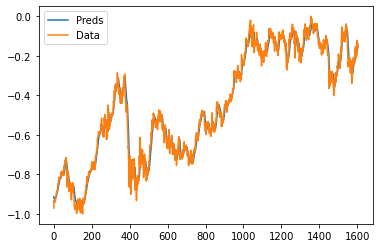

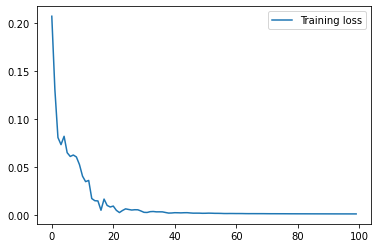

In [57]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [58]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.85 RMSE
Test Score: 6.01 RMSE


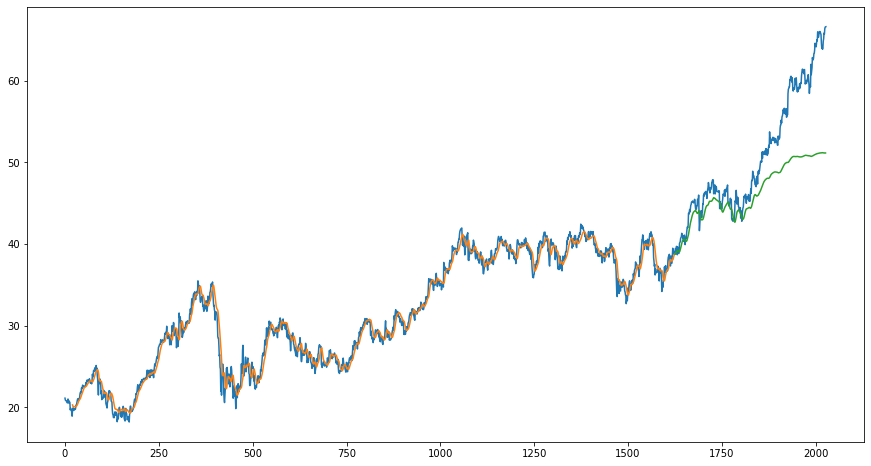

In [61]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_ibm)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [62]:
y_test

array([[38.829   ],
       [39.459   ],
       [39.419   ],
       [39.155003],
       [39.718998],
       [39.425   ],
       [38.687   ],
       [39.652   ],
       [38.892002],
       [38.961   ],
       [38.833   ],
       [39.170002],
       [40.095   ],
       [40.183   ],
       [40.311   ],
       [40.704998],
       [40.794   ],
       [40.913   ],
       [41.317   ],
       [41.188   ],
       [41.021   ],
       [40.715   ],
       [40.973   ],
       [40.578   ],
       [40.321   ],
       [41.1     ],
       [40.638   ],
       [39.928   ],
       [40.36    ],
       [40.824   ],
       [40.724   ],
       [41.386   ],
       [41.839   ],
       [42.105   ],
       [41.997   ],
       [42.313   ],
       [43.759003],
       [43.672   ],
       [43.909   ],
       [44.232998],
       [43.919   ],
       [44.372   ],
       [44.756   ],
       [44.844   ],
       [45.149   ],
       [45.149   ],
       [45.218002],
       [45.277   ],
       [45.228   ],
       [45.052002],
